# Домашнее задание 2

В этом домашнем задании мы поупражняемся с ETS-моделью и STL-разложением. Сначала коротко про данные.

Представьте себе стандартный банкомат, который работает только на выдачу. Его нужно периодически пополнять наличностью, чтобы он функционировал непрерывно. Однако выезд инкассаторов является делом хлопотным и недешёвым, так что хотелось бы не гонять их лишний раз заполнять наполовину полный банкомат. Хотелось бы научиться предсказывать спрос людей на наличность в банкомате, чтобы можно было предсказывать время, когда количество денег в банкомате снизится до минимально допустимой величины. Этим мы и займёмся. Для простоты возьмём один конкретный банкомат. Нам доступны объёмы выдачи в банкомате по дням.

##### 1) Загрузка данных и визуальный анализ (1 балл)

Важно! sktime довольно капризен в плане форматов даты-времени. Для работы некоторых функций может требоваться PeriodIndex или DateTimeIndex. Часто самые непонятные ошибки происходят из-за этого. К сожалению, на текущий момент это данность, но мы в вас верим.

Загрузите данные из файла atm.csv. Изобразите временной ряд, его автокорреляции (можно ещё автокорреляции первых разностей для большей ясности).  Что вы можете сказать о структуре ряда? Присутствует ли в нём тренд? Сезонность? Цикличность? Опишите, как сделанные вами наблюдения помогут построить модель.

In [54]:
import warnings
warnings.filterwarnings('ignore')

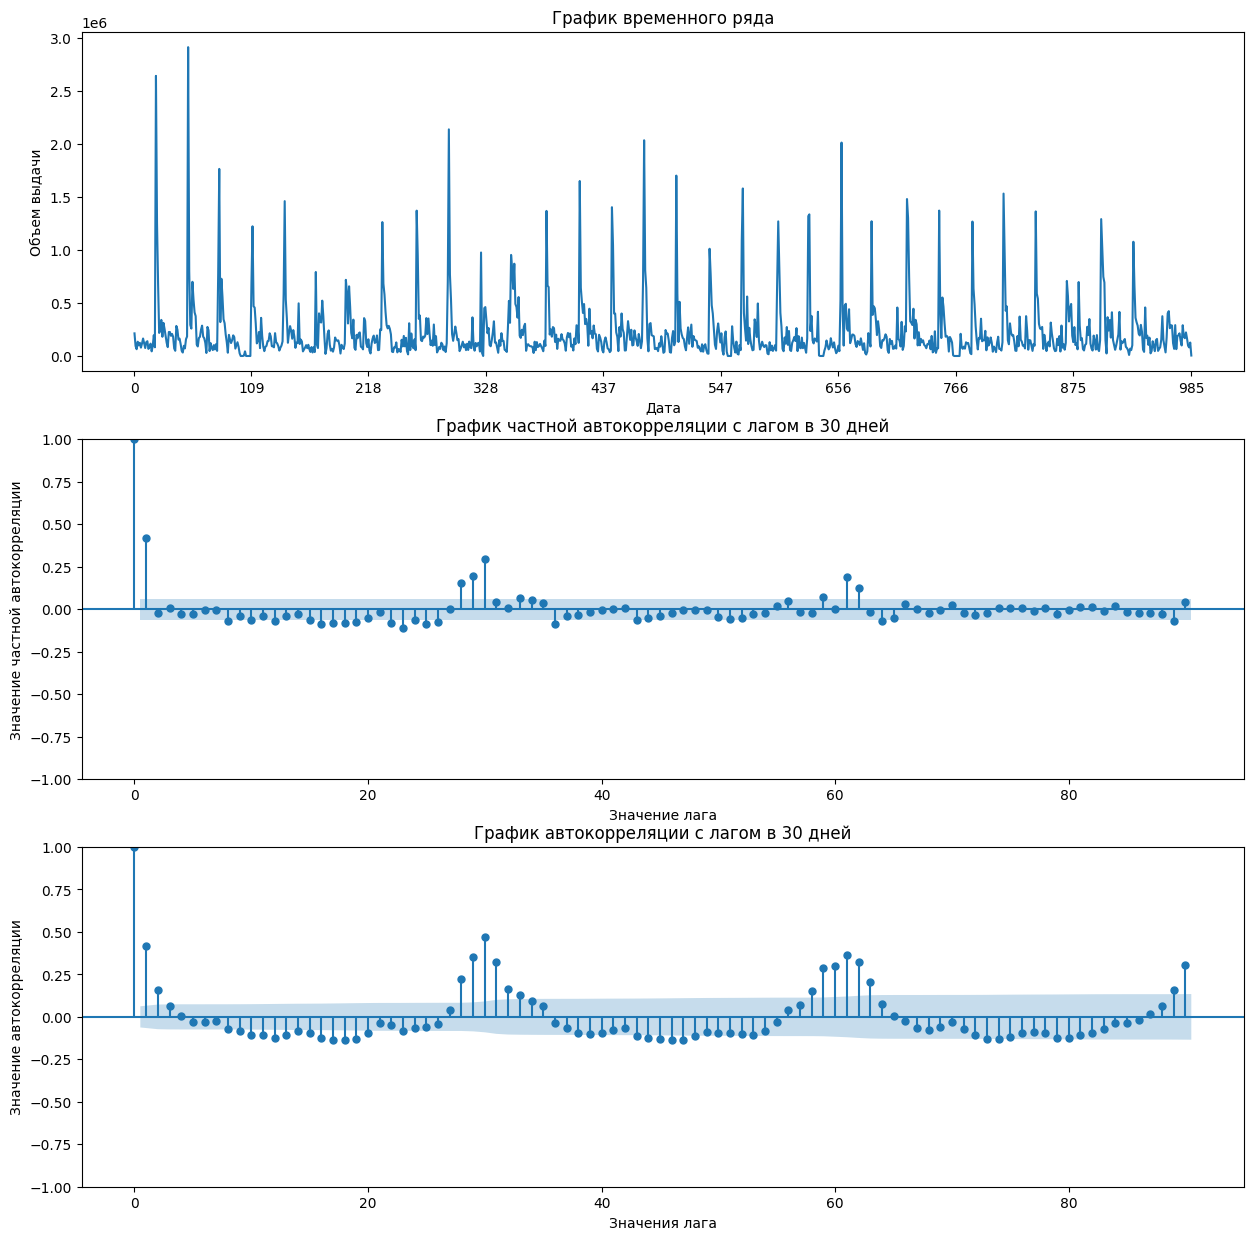

In [55]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sktime.utils.plotting import plot_correlations

from sktime.forecasting.base import ForecastingHorizon

import warnings
warnings.filterwarnings('ignore')

y = pd.read_csv('/Users/vsevolodparamonov/Downloads/hw2/atm.csv')
X = pd.read_csv('/Users/vsevolodparamonov/Downloads/hw2/events.csv')

X = X[X['Unnamed: 0'].isin(y['Unnamed: 0'].values)].reset_index(drop=True).rename(columns={'Unnamed: 0': 'Date'})
X.Date = pd.to_datetime(X.Date)

y = y.drop('Unnamed: 0', axis=1)


f, ax = plt.subplots(3,1,figsize=(15,15))

ax[0].plot(y.index, y.target)
ax[0].set_title('График временного ряда')
ax[0].set_ylabel('Объем выдачи')
ax[0].set_xlabel('Дата')
ax[0].set_xticks(y.index[np.linspace(0, y.index.shape[0] - 1, 10).astype('int')])

plot_pacf(y, lags=90, ax=ax[1])
ax[1].set_title('График частной автокорреляции с лагом в 30 дней')
ax[1].set_xlabel('Значение лага')
ax[1].set_ylabel('Значение частной автокорреляции')

plot_acf(y, lags=90, ax=ax[2])
ax[2].set_title('График автокорреляции с лагом в 30 дней')
ax[2].set_xlabel('Значения лага')
ax[2].set_ylabel('Значение автокорреляции');

> #### **<div style='color:red'> Решение: </div>**
>
> * #### _**Тренд:**_ Довольно сложно определить по графику тренд, но я бы сказал, что он тут отсутствует
>
> * #### _**Сезонность:**_ По графикам автокорреляций видно, что присутствует месячная сезонность в графике временного ряда
>
> * #### _**Цикличность:**_ В графике можно заметить повторяющиеся паттерны $\Rightarrow$ можно предположить, что в данных наблюдается цикличность

##### 2) Предобработка данных (0.5 балла)

Разбейте данные на трейн и тест. Размер теста: последние 50 дней.

Как легко заметить, данные неотрицательны. Но на случай использования мультипликативных моделей рекомендуется децентировать трейн в положительную полуось. Дополнительно можете произвести на трейне обратимые преобразования, которые сочтёте необходимыми (Box-Cox, детрендирование и т.п.).

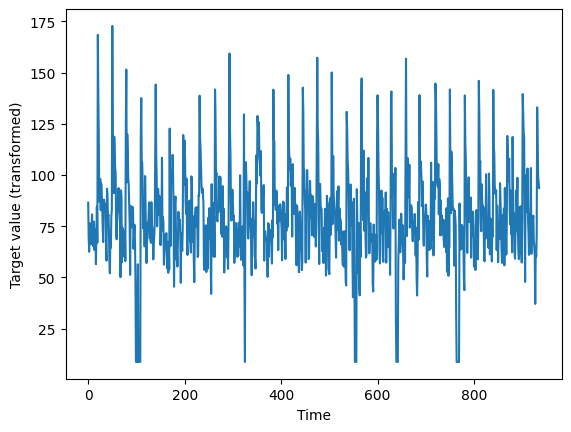

In [56]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.transformations.series.boxcox import BoxCoxTransformer

y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=50)

trans = BoxCoxTransformer()

y_train = trans.fit_transform(y_train + 100)

plt.plot(y_train)
plt.xlabel('Time')
plt.ylabel('Target value (transformed)');

### Блок 1. STL/MSTL


Здесь и далее будем работать только с трейном. В данном разделе мы попробуем декомпозировать ряд с помощью STL или MSTL. В этом случае наш ряд можно представить в следующем виде:

$$y^{train}_t = t_t + s_t + e_t$$

 $t_t$ - компонента трейна

 $s_t$ - компонента сезонности, в случае MSTL будет несколько компонент сезонности
 
 $e_t$ - компонента остатков


Для каждой компоненты мы будем оценивать отдельную многошаговую модель. Компоненты тренда и сезонности обычно простые по своей структуре. Для них мы будем использовать какие-нибудь тривиальные модели. Компонента остатков обычно самая сложная, так как включает в себя "всё остальное". Для неё мы будем строить модель с признаками аналогично ДЗ-1.

Каждую компоненту необходимо будет многошагово спрогнозировать на тестовый период. Так как STL-разложение аддитивно, прогнозы мы просто просуммируем.

$$\hat{y}^{test}_t = \hat{t}_t + \hat{s}_t + \hat{e}_t$$

Таким образом мы получим итоговый прогноз.


##### Разложение (0.3 балла)

Начнём с STL. Примените на трейне STL или MSTL-разложение (обоснуйте выбор). Обоснуйте период(ы), который вы берёте в качестве сезонного. Визуализируйте отдельные компоненты.

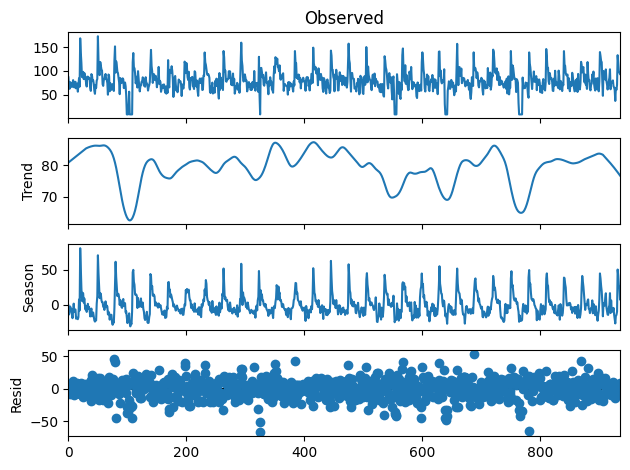

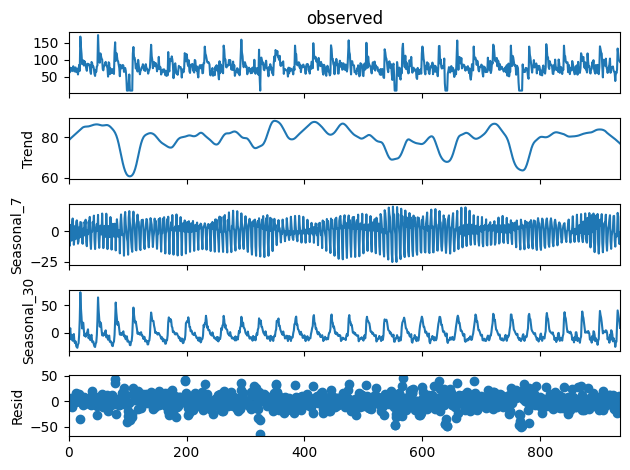

In [57]:
from statsmodels.tsa.seasonal import STL, MSTL

stl_model = STL(y_train, period=30).fit()
stl_model.plot();

mstl_model = MSTL(y_train, periods=[7, 30]).fit()
mstl_model.plot();

##### Прогнозирование тренда (0.3 балла)

Достаньте из оценённой модели компоненту тренда. Спрогнозируйте этот ряд на длину теста любой простой моделью в зависимости от вида ряда (Наивная, RandomWalk, любой алгоритм сглаживания, ...).

In [58]:
from statsmodels.tsa.ar_model import AutoReg

trend_AR = AutoReg(stl_model.trend[7:], lags=30).fit()
y_naive_trend = trend_AR.predict(start=y_test.index[0], end=y_test.index[-1])

##### Прогнозирование сезонности (0.3 балла)

Достаньте из модели компоненту или компоненты сезонности. Аналогично спрогнозируйте любой простой моделью без фичей.

In [59]:
season_AR = AutoReg(stl_model.seasonal[7:], lags=7).fit()
y_naive_seas = season_AR.predict(start=y_test.index[0], end=y_test.index[-1])

#### Прогнозирование остатков. 

Теперь возьмёмся за самую сложную часть, прогнозирование компоненты остатков. Достаньте из модели эту компоненту.


In [60]:
y_res = stl_model.resid


##### Подготовка данных (0.9 балла)

Многошаговый прогноз остатков потребует уже модели с фичами. По сути эта задача эквивалентна многошаговому прогнозированию из ДЗ-1. Стратегия многошагового прогнозирования и выбор модели также остаётся на ваше усмотрение. В текущем пункте вам необходимо подготовить фичи для модели. В этот раз вам не будет дано конкретных указаний по генерации переменных. Но будет выдана дополнительная информация о банкомате. Можете её использовать, можете нет, на ваше усмотрение. 

Расположение: ул Крымский Вал, 9стр45

Дополнительная информация: ГАУК культуры города Москвы ЦПКиО им. М.Горького

Широта: 55.73259

Долгота: 37.600891

Также в помощь прилагается файл с различными календарными фичами (events.csv), чтобы не повторять в этой домашке то же самое, что в прошлой. Можете использовать любые фичи из этого файла, но для засчитывания пункта необходимо придумать минимум три фичи (по 0.3 за каждую), не входящие в приложенный файл. Каждую используемую фичу (не важно, из файла или придуманную вами) необходимо кратко обосновать. Не забывайте учитывать потенциальные утечки. За их наличие балл также может быть снижен.

Результатом пункта должны быть вектор e_train и матрица e_X_train для модели остатков.

In [61]:
X_train['year'] = X_train.Date.dt.year
X_train['month'] = X_train.Date.dt.month

X_test['year'] = X_test.Date.dt.year
X_test['month'] = X_test.Date.dt.month

> ### **ИПЦ**
>
> #### В случае высокого показателя ИПЦ ожидается, что люди будут уменьшать объем сбережений $\Rightarrow$ объемы выдачи наличных будут высоки

In [62]:
ipc = pd.read_excel('/Users/vsevolodparamonov/Desktop/IPC.xls')

month = {'Январь': 1,
         'Февраль': 2,
         'Март': 3,
         'Апрель': 4,
         'Май': 5,
         'Июнь': 6,
         'Июль': 7,
         'Август': 8,
         'Сентябрь': 9,
         'Октябрь': 10,
         'Ноябрь': 11,
         'Декабрь': 12}

ipc['Месяц'] = ipc['Месяц'].map(month)

X_train = pd.merge(X_train, ipc, left_on=['year', 'month'], right_on=['Год', 'Месяц'], how='left').drop(['Год', 'Месяц'], axis=1)

> ### **Курс доллара**
>
> #### Может быть потенциально полезным признаком, поскольку в случае выгодного курса ожидается повышенный спрос на ту или иную валюту (макроэкономическая интуиция)

In [63]:
import yfinance as yf

ticker = 'USDRUB=X'

start_date = '2015-01-01'
end_date = '2017-09-12'

data_yf = yf.download(ticker, start=start_date, end=end_date)

exch_rates = pd.DataFrame({
    'Date': data_yf.index,
    'exch_rate': data_yf['Adj Close']
})

exch_rates.reset_index(drop=True, inplace=True)

X_train = pd.merge(X_train, exch_rates, on='Date', how='left').drop('Date', axis=1)
X_train.exch_rate = X_train.exch_rate.interpolate()


[*********************100%%**********************]  1 of 1 completed


> ### **Sin**
>
> #### Стандартный признак для того, чтобы задать цикличность

In [64]:
X_train.loc[:,'sin'] = np.sin(2 * np.pi * (np.arange(X_train.shape[0]) / 7))
X_test.loc[:,'sin'] = np.sin(2 * np.pi * ((X_train.shape[0] + np.arange(X_test.shape[0])) / 7))

In [65]:
X_train.loc[:, ['ИПЦ', 'exch_rate']] = X_train.loc[:, ['ИПЦ', 'exch_rate']].shift(1)

X_train = X_train[1:]
y_res = y_res[1:]

#### Кросс-валидация

Теперь займёмся подбором оптимальной модели остатков. Для этого используем кросс-валидацию.

##### Реализация метода (0.6 балла)

Реализуйте метод скользящего окна. Реализуйте класс, который будет по входным параметрам окна выдавать индексы всех фолдов. По поведению можно ориентироваться на знакомый вам k-fold. Хорошей практикой будет возвращать в методе split генератор, хотя это и не обязательно. На каждом фолде модель будет обучаться на трейне и делать многошаговый прогноз на тест. 

Позаботьтесь о том, чтобы ширина окна была соотнесена в логичной пропорции с горизонтом прогнозирования. Длина трейна 55 при горизонте 50 -- сомнительная практика.


In [66]:
import pandas as pd

class CustomCrossVal:
    def __init__(self, window_size:int, step:int):

        '''Args:
            window_size (int): The size of window. For expanding window -- initial size of window
            step (int): Window step. For expanding window is a growth of window. For sliding window is number of obs to slide.
        '''
        
        self.window_size = window_size
        self.step = step

    def split(self, y:pd.Series, X: pd.DataFrame):
        '''Args:
            X (pandas DataFrame): Dataframe to split.
           '''
        finish = len(X)

        y_train_batch, X_train_batch, y_test_batch, X_test_batch = [], [], [], []

        while finish - self.window_size >= 4 * self.window_size:

            X_train_batch.append(X[:finish - self.window_size])
            y_train_batch.append(y[:finish - self.window_size])

            X_test_batch.append(X[finish - self.window_size: finish])
            y_test_batch.append(y[finish - self.window_size: finish])

            finish -= self.step

        return y_train_batch, X_train_batch, y_test_batch, X_test_batch


##### Отбор моделей (0.5 балла)

Выберите несколько моделей-кандидатов исходя из свойств ряда (обоснуйте) и отберите с помощью реализованной вами кросс-валидации наилучшую. Можно использовать разные модели либо разные наборы фичей. Метрика: MAE.

In [67]:
from sklearn.metrics import mean_absolute_error

def cv_score(model, X, y, strategy, window_size = 50, step = 15):

    cv = CustomCrossVal(window_size, step)

    y_train_batch, X_train_batch, y_test_batch, X_test_batch = cv.split(y, X)

    mae = 0
    denom = sum([x.shape[0] for x in y_train_batch])

    for i in range(len(y_train_batch)):

        fh = ForecastingHorizon(y_test_batch[i].index, is_relative=False)
        fh = len(y_test_batch[i])

        if strategy == 'direct':

            model.fit(X_train_batch[i], y_train_batch[i], fh)

        elif strategy == 'recursive':
            model.fit(X_train_batch[i], y_train_batch[i], fh, [7, 30])

        elif strategy == 'ETS':

            model.fit(y_train_batch[i])

        nomin = len(X_train_batch[i])

        if strategy == 'ETS':

            mae += (nomin / denom) * mean_absolute_error(y_test_batch[i], model.predict(fh=y_test_batch[i].index))

        else:
            mae += (nomin / denom) * mean_absolute_error(y_test_batch[i], model.predict(X_test_batch[i]))

        
    return mae


##### Прогноз моделей (0.5 балла)

Обучите наилучшую модель остатков на всём трейне и постройте прогноз на тестовый период, используя выбранную вами многошаговую стратегию.

In [68]:
from catboost import CatBoostRegressor
from statsmodels.tsa.ar_model import AutoReg


class make_reduction:

    """

    Класс, созданный для рекурсивной стратегии

    """

    def __init__(self, base_estimator, strategy, endog_feats):

        self.strategy = strategy
        self.base_estimator = base_estimator
        self.endog_feats = endog_feats

    def fit_endog_fits(self, fh, X):

        

        output = pd.DataFrame()

        for feat in self.endog_feats:
            
            pred = AutoReg(X[feat], lags=7).fit().predict(start = X.index[-1]+1, end=X.index[-1] + fh).values

            output.loc[:, feat] = pred

        return output.dropna()



    def fit(self, X, y, fh=None, lags=None, on_train = False):

        """

        Обучение базовой модели + генерация лаговых перменных
        
        """

        self.fh = fh
        self.lags = lags if (type(lags) == list or lags == None) else [lags]
        self.on_train = on_train

        if self.strategy == 'direct' and fh == None:

            raise ValueError('Direct strategy  missing "fh" parametr')

        if self.strategy == 'recursive':

            if self.lags:


                for lag in self.lags:

                    X[f'LAG_{lag}'] = y.shift(lag)

                self.X = X.loc[max(self.lags) + 1:].reset_index(drop=True)
                self.y = y.loc[max(self.lags) + 1:].reset_index(drop=True)

            else:

                self.X = X.reset_index(drop=True)
                self.y = y.reset_index(drop=True)

            self.end_feats = self.fit_endog_fits(self.fh, self.X)
            self.base_estimator.fit(self.X, self.y)

        elif self.strategy == 'direct':

            self.estimators = [self.base_estimator for k in range(fh)]

            for i in range(1, fh+1):

                y_train = y.loc[i : y.shape[0]]
                X_train = X.loc[0 : X.shape[0]-(i+1)]
                
                self.estimators[i].fit(X_train, y_train)

    def predict(self, X):

        """

        Предсказание

        """

        endog_feats = self.end_feats.loc[:min(self.fh, X.shape[0]) - 1].values

        X.loc[:, self.endog_feats] = endog_feats
        X = X.reset_index(drop=True)

        if self.strategy == 'direct':

            y_pred = []

            for i in range(min(X.shape[0], self.fh)):

                y_p = self.estimators[i].predict(X.iloc[i].values.reshape(-1,1).T)

                y_pred.append(y_p)


        elif self.strategy == 'recursive':

            y_story = list(self.y[self.y.shape[0] - max(self.lags):].values.ravel())
            y_pred = []            

            for i in range(self.fh):

                X_test = X.loc[i]

                if self.lags != None:

                    for lagg in self.lags:

                        X_test[f'LAG_{lagg}'] = y_story[-lagg]

                    X_test = X_test.values.reshape(-1,1).T

                y_story = y_story[1:]

                y_story.append(self.base_estimator.predict(X_test)[0])
                y_pred.append(self.base_estimator.predict(X_test)[0])

        return y_pred
    


In [69]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRFRegressor

from catboost import CatBoostRegressor

rec_catboost = make_reduction(XGBRFRegressor(), 'recursive', endog_feats=['ИПЦ', 'exch_rate'])
rec_forest = make_reduction(RandomForestRegressor(), 'recursive', endog_feats=['ИПЦ', 'exch_rate'])
rec_tree = make_reduction(DecisionTreeRegressor(), 'recursive', endog_feats=['ИПЦ', 'exch_rate'])


names = ['Recursive strategy with XGBoost: ', 'Recursive strategy with RandomForest: ', 'Recursive strategy with DecisionTree: ']
models = [rec_catboost, rec_forest, rec_tree]


for name, model in zip(names, models):

    if 'Direct' in name:

        mae = cv_score(model, X_train.copy(), y_res.copy(), 'direct', 50, 25)

    elif 'Recursive' in name:

        mae = cv_score(model, X_train.copy(), y_res.copy(), 'recursive', 50, 25)

    else: pass

    print(name, mae)


Recursive strategy with XGBoost:  9.568689515619948
Recursive strategy with RandomForest:  9.899369078259516
Recursive strategy with DecisionTree:  13.59762348904893


> #### **<div style='color:red'>Вывод: </div>**
>
> #### Модель <code>XGBoost</code> показала лучший результат на кросс-валидации, следовательно, возьмем ее для дальнейшего использования

##### Результаты и визуализация (0.6 балла)

Соберите в сумму прогнозы всех компонент STL-разложения на тесте. Не забудьте на сумму прогнозов компонент применить преобразования, обратные тем, которые были сделаны на трейне.  Визуализируйте прогноз и тестовые данные. Подсчитайте MAE прогноза.

In [70]:
rec_catboost.fit(X_train, y_res, X_test.shape[0], [7, 30, 60])
hat_e = rec_catboost.predict(X_test.drop('Date', axis=1))

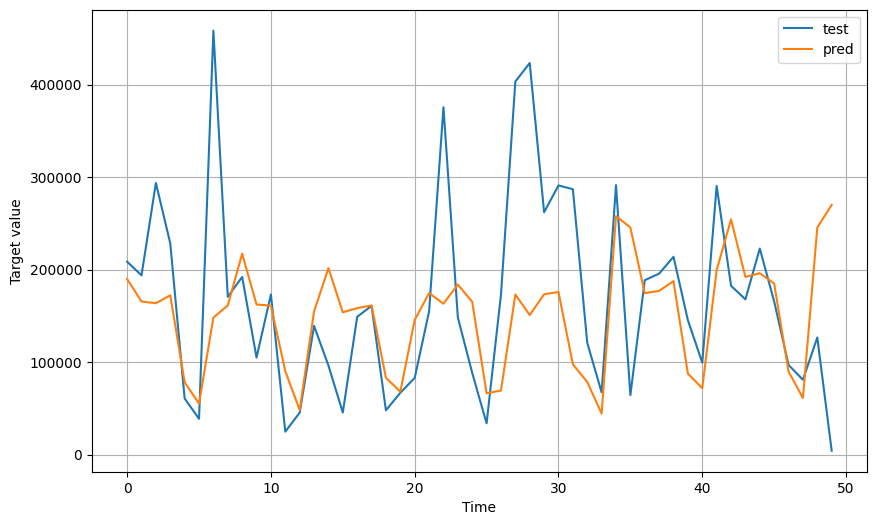

In [71]:
y_pred = trans.inverse_transform(y_naive_trend.values.ravel() + y_naive_seas.values + hat_e) - 100

plt.figure(figsize=(10, 6))
plt.plot(y_test.reset_index(drop=True), label='test')
plt.plot(y_pred, label='pred')

plt.xlabel('Time')
plt.ylabel('Target value')

plt.grid()
plt.legend();


In [72]:
print(f'MAE: {mean_absolute_error(y_test.values, y_pred)}')

MAE: 70631.80763466733


##### Бэктестинг (0.75 балла)

Попробуем протестировать in-sample итоговую модель, которая получилась. Для этого нам необходимо получить остатки суммарной модели на трейне. Для этого нам необходимо вернуться к моделям отдельных компонент и построить одношаговые прогнозы на всём участке train.

$$e^{clean}_t = y^{train}_t - (\hat{t}^{train}_t + \hat{s}^{train}_t + \hat{e}^{train}_t)$$

Нарисуйте графики автокорреляций этих остатков. Есть ли в каких-то интересных датах значимые пики? Как думаете, с чем эти ошибки модели связаны? (0.5 балла)

Проведите тест Ljung-Box. Протестируйте остатки на наличие серийных автокорреляций при нескольких m. Проинтерпретируйте результаты теста $\alpha = 0.05$. (0.25 балла)

Если нулевая гипотеза отвергается, можете попытаться улучшить модель и поискать фичи по графикам автокорреляций, но это опционально. В ряде ситуаций становится сложно построить модель, в которой гипотеза не отвергается, поэтому иногда на наличие автокорреляций закрывают глаза.

In [73]:
trend_naive = trend_AR.predict(start=y_train.index[0], end=y_train.index[0] + y_train.shape[0])
seas_naive = season_AR.predict(start=y_train.index[0], end=y_train.index[0] + y_train.shape[0])

for i in range(1, 11):

    X_train[f'LAG_{i}'] = y_train.shift(i)

In [74]:
X_train = X_train.loc[10:, :]
y_train = y_train.loc[10:]
trend_naive = trend_naive.loc[10:]
seas_naive = seas_naive.loc[10:]
y_res = y_res.loc[10:]

In [75]:
e_clean = y_train.values.ravel() - trend_naive[:-1] - seas_naive[:-1] - CatBoostRegressor(verbose=False).fit(X_train, y_res).predict(X_train)

<Figure size 1000x600 with 0 Axes>

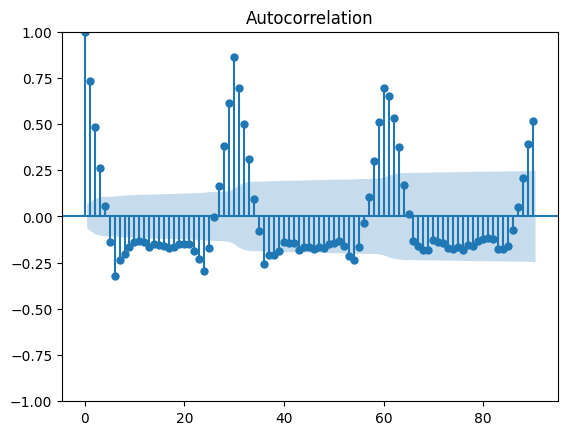

In [76]:
plt.figure(figsize=(10, 6))

plot_acf(e_clean[~np.isnan(e_clean)], lags=90);

In [77]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lags = [5, 10, 15]

acorr_ljungbox_test = pd.DataFrame()

for lag in lags:

    test_results = acorr_ljungbox(hat_e, lags=lag, return_df=True)

    data_for_ljungbox = [lag, test_results['lb_stat'].values[-1], round(test_results['lb_pvalue'].values[-1],3)]

    acorr_ljungbox_test[lag // 5 - 1] = data_for_ljungbox

acorr_ljungbox_test = acorr_ljungbox_test.T.rename(columns={0: 'Lag value', 1:'Statistic', 2:'P-value'})

acorr_ljungbox_test['Reject?'] = acorr_ljungbox_test['P-value'].apply(lambda x: 'YES' if x <= 0.05 else 'NO')
acorr_ljungbox_test

,Lag value,Statistic,P-value,Reject?
0,5.0,31.223165,0.0,YES
1,10.0,86.519659,0.0,YES
2,15.0,129.593403,0.0,YES


> ### **<div style='color:red'> Выводы: </div>**
>
> #### Нулевая гипотеза об отсутствии автокорреляции отвергается, что значит, что остатки модели содержат какую-то информацию, которую модель не учла

### Блок 2. ETS-модель

Теперь повторим то же самое, только моделировать тренд и сезонность будем ETS-моделью, а на остатки ETS-модели навешивать вторую модель.

$$y^{train}_t = y^{ETS}_t + e^{ETS}_t$$


##### Визуальный анализ (1 балл)

Вернитесь к y_train. Взгляните на ряд и опишите, какие из вариантов ETS-модели подошли бы под наши данные. Сформируйте сетку параметров для моделей-кандидатов. Кратко поясните каждую опцию, которую вы включаете в сетку, основываясь на визуальном анализе.

> ### **<div style='color:red'> Анализ: </div>**
>
> #### По графику временного ряда можно скзать, что отсутствует как таковой тренд, но зато присутствует аддитивная сезонность. Для более точного выбора переберем все возможные комбинации параметров модели и убедимся в том, что изначальные предположения про тренд и сезонность верны:

In [78]:
from itertools import product
from sktime.forecasting.ets import AutoETS

err, tr, ss, dump = ['add', 'mul', None], ['add', 'mul', None], ['add', 'mul', None], [True, False]

all_ets = list(product(tr, ss, err, dump))


##### Кросс-валидация (0.3 балла)

С помощью кросс-валидации выберите наилучшую по MAE ETS-модель. Обучите её на всём трейне и спрогнозируйте на тест. 

In [79]:
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=50)


transf = BoxCoxTransformer()
y_train = transf.fit_transform(y_train + 100)

all_ets_model = pd.DataFrame()

for k in all_ets:

    for sp in range(30, 34):

        try:
            args = {name: value for name, value in zip(['error', 'trend', 'seasonal', 'damped_trend'],k) if value != None}
            args['sp'] = sp

            model = AutoETS(**args)
            mae = cv_score(model, X_train, y_train, 'ETS')
            break

        except:
            pass


    data_for_ETS = [k[0], k[1], k[2], k[3], sp, mae]

    all_ets_model = pd.concat([all_ets_model, pd.DataFrame(data_for_ETS).T.rename(columns={0:'Error', 1:'Trend', 2:'Season', 3:'Dumped Trend', 4:'sp', 5: 'MAE'})])

all_ets_model.reset_index(drop=True)

,Error,Trend,Season,Dumped Trend,sp,MAE
0,add,add,add,True,30,21.52478
1,add,add,add,False,30,25.511513
2,add,add,mul,True,30,24.37039
3,add,add,mul,False,30,74.266754
4,add,add,None,True,30,25.996291
5,add,add,None,False,30,44.161323
6,add,mul,add,True,30,21.280493
7,add,mul,add,False,30,34.139697
8,add,mul,mul,True,30,24.404921
9,add,mul,mul,False,30,81.194899


In [80]:
all_ets_model[all_ets_model.MAE == all_ets_model.MAE.min()]

,Error,Trend,Season,Dumped Trend,sp,MAE
0,mul,None,None,False,30,16.554913


> #### **<div style='color:red'> Вывод: </div>**
>
> #### По итогу лучшей моделью оказалась модель с мультипликативной ошибкой, отсутсвующими трендом и сезонностью, а также без дампированного тренда. В дальнейшем будем использовать ее

In [81]:
win_model = AutoETS(error='mul', damped_trend=False, sp=30).fit(y_train)

##### Подготовка данных (0.1 балла)

Достаньте остатки ETS-модели на трейне.
            $$e_{ETS} = y_{train} - \hat{y}_{train}$$

Это можно сделать с помощью метода predict_residuals. Построим на временном полученном временном ряде многошаговую модель. Можно использовать те же фичи, что и в разделе про STL, без дополнительных пояснений. Если вводите новые фичи, коротко поясните каждую. Результатом пункта должны быть вектор e_train и матрица e_X_train для модели остатков.

In [82]:
e_ets = win_model.predict_residuals(y_train)

##### Отбор моделей и кросс-валидация (0.5 баллов)

Отберите несколько моделей-кандидатов для прогнозирования остатков и отберите на кросс-валидации наилучшую по MAE модель. Размер валидации на каждом фолде всё также равен длине тестовой выборки. Используйте реализованный ранее класс для кросс-валидации. 

In [83]:
X_train['year'] = X_train.Date.dt.year
X_train['month'] = X_train.Date.dt.month

X_test['year'] = X_test.Date.dt.year
X_test['month'] = X_test.Date.dt.month

X_train = pd.merge(X_train, ipc, left_on=['year', 'month'], right_on=['Год', 'Месяц'], how='left').drop(['Год', 'Месяц'], axis=1)
X_train = pd.merge(X_train, exch_rates, on='Date', how='left').drop('Date', axis=1)
X_train.exch_rate = X_train.exch_rate.interpolate()

X_train.loc[:, ['ИПЦ', 'exch_rate']] = X_train.loc[:, ['ИПЦ', 'exch_rate']].shift(1)

X_train = X_train[1:]
e_ets = e_ets[1:]

X_train_1, X_train_2 = X_train.copy(), X_train.copy()

In [84]:
for name, model in zip(names, models):

    if 'Direct' in name:

        mae = cv_score(model, X_train_1, e_ets, 'direct', 50, 25)

    elif 'Recursive' in name:

        mae = cv_score(model, X_train_1, e_ets, 'recursive', 50, 25)

    else: pass

    print(name, mae)


Recursive strategy with XGBoost:  15.668471879623622
Recursive strategy with RandomForest:  15.153740369305885
Recursive strategy with DecisionTree:  21.825501060878068


> #### **<div style='color:red'>Вывод: </div>**
>
> #### Модель <code>RandomForest</code> показала лучший результат на кросс-валидации, обогнав <code>XGBoost</code>, следовательно, будем использовать ее

##### Прогноз остатков ETS (0.5 баллов)
Обучите наилучшую модель на всём наборе остатков трейна. Постройте прогноз на тест с помощью любой многошаговой стратегии.

Суммируйте прогнозы двух компонент в итоговый прогноз. Не забудьте в конце наложить обратные преобразования ряда, если вы их делали в самом начале.

$$\hat{y}^{test}_t = \hat{y}^{ETS}_t + \hat{e}^{ETS}_t$$

Подсчитайте MAE.


In [85]:
rec_catboost.fit(X_train_1, e_ets, X_test.shape[0], [7, 30, 60])
e_ets_pred = rec_forest.predict(X_test.drop('Date', axis=1))
y_ets_pred = win_model.predict(fh=ForecastingHorizon(y_test.index, is_relative=False))

y_pred_ETS = trans.inverse_transform(y_ets_pred.values.ravel() + e_ets_pred) - 100

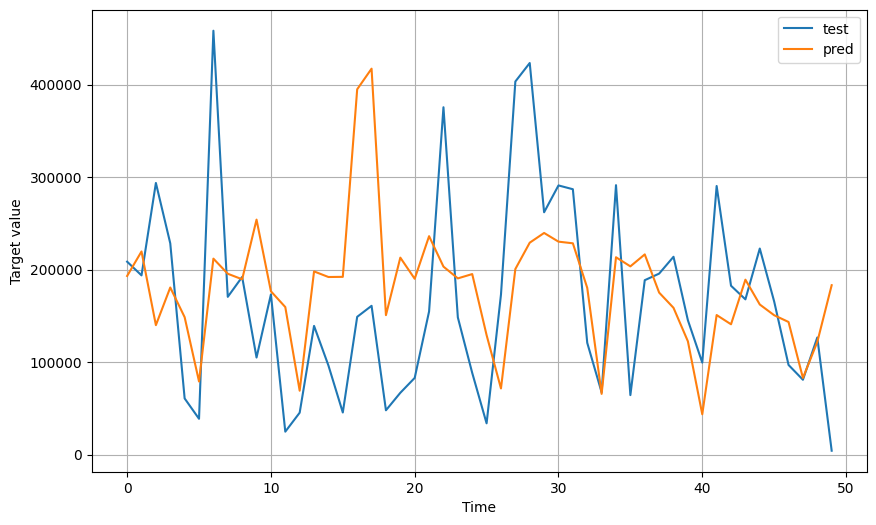

In [86]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.reset_index(drop=True), label='test')
plt.plot(y_pred_ETS, label='pred')

plt.grid()
plt.xlabel('Time')
plt.ylabel('Target value')
plt.legend();

In [87]:
print(f'MAE: {mean_absolute_error(y_test.values, y_pred_ETS)}')

MAE: 84451.63941261935


##### Бэктестинг (0.5 балла)

Найдите остатки одношаговых моделей на тренировочной выборке.

$$e^{cleaned}_t = y^{train}_t - (\hat{y}^{ETS}_t + \hat{e}^{ETS}_t) $$

Так как получить одношаговые прогнозы $\hat{y}^{ETS}_t$ класс из Sktime почему-то не позволяет. Но мы помним, что 

 $$e_{ETS} = y^{train}_t - \hat{y}^{train}_t$$
 
Это выражение можно развернуть и получить искомое.

$$\hat{y}^{ETS}_t = y^{train}_t - e_{ETS}$$

А $e_{ETS}$ мы уже получали с помощью predict_residuals

Таким образом вы получите финальные остатки вашей двухуровневой модели. Нарисуйте графики автокорреляций этих остатков, проинтерпретируйте. Протестируйте их на наличие серийных автокорреляций тестом Ljung-Box.

In [88]:
rec_forest.fit(X_train_2.loc[11:].reset_index(drop=True), e_ets.loc[11:].reset_index(drop=True), X_train_2.loc[11:].shape[0], list(np.arange(1, 12)), True)

e_ets_train = rec_forest.predict(X_train_2.loc[11:])

e_clean = e_ets.loc[11:].values.ravel() - np.array(e_ets_train)

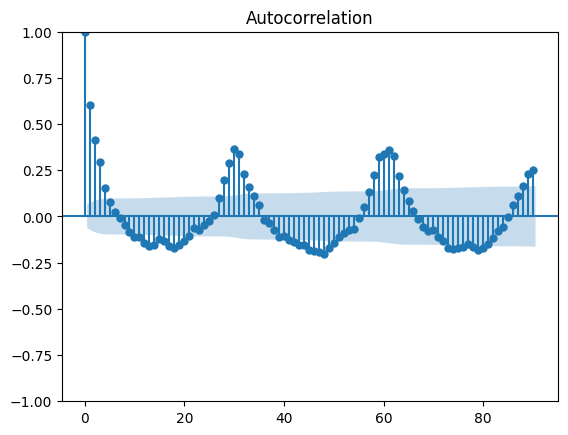

In [89]:
plot_acf(e_clean, lags=90);

In [90]:
lags = [5, 10, 15]

acorr_ljungbox_test = pd.DataFrame()

for lag in lags:

    test_results = acorr_ljungbox(e_clean, lags=lag, return_df=True)

    data_for_ljungbox = [lag, test_results['lb_stat'].values[-1], round(test_results['lb_pvalue'].values[-1],3)]


    acorr_ljungbox_test[lag // 5 - 1] = data_for_ljungbox

acorr_ljungbox_test = acorr_ljungbox_test.T.rename(columns={0: 'Lag value', 1:'Statistic', 2:'P-value'})

acorr_ljungbox_test['Reject?'] = acorr_ljungbox_test['P-value'].apply(lambda x: 'YES' if x <= 0.05 else 'NO')
acorr_ljungbox_test

,Lag value,Statistic,P-value,Reject?
0,5.0,604.011498,0.0,YES
1,10.0,624.595554,0.0,YES
2,15.0,716.298658,0.0,YES


> ### <div style='color:red'> Вывод: </div>
>
> #### В данном случае получилось все аналогично предыдущему заданию

#### Сравнение моделей

##### Визуальный анализ (0.2 балла)

Визуализируйте прогнозы STL, ETS и тестовые значения на графике. Добавьте небольшой отрезок тренировочных данных, так получится более приятный график. Сравните метрики прогнозов. Какая из двух моделей получилась лучше? Как думаете, почему? 

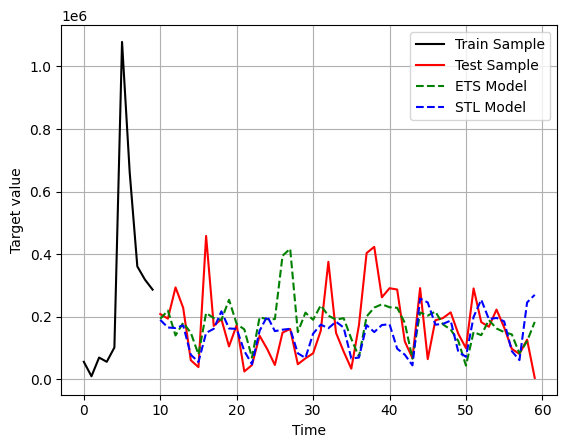

In [91]:
train_size = 10

plt.plot(np.arange(train_size), trans.inverse_transform(y_train[-train_size:]) - 100, color='black', label='Train Sample')
plt.plot(np.arange(train_size, y_test.shape[0] + train_size), y_test, label='Test Sample', color='red')
plt.plot(np.arange(train_size, y_test.shape[0] + train_size), y_pred_ETS, label='ETS Model', color='green', linestyle='--')
plt.plot(np.arange(train_size, y_test.shape[0] + train_size), y_pred, label='STL Model', color='blue', linestyle='--')
plt.legend()

plt.xlabel('Time')
plt.ylabel('Target value')
plt.grid();



##### Сравнение  моделей (0.65 балла)

(0.2 балла) Возьмите бенчмарк в виде сезонной наивной модели, подобрав период сезонности. Постройте прогноз такой модели на тест и подсчитайте MAE. Преодолела ли хотя бы одна модель этот бенчмарк?

In [92]:
from sktime.forecasting.naive import NaiveForecaster

forecaster = NaiveForecaster(strategy="last", sp=7)

best_forecaster = None
min_mae = np.inf

for i in np.linspace(7, 60, 10).astype('int'):

    forecaster = NaiveForecaster(strategy="last", sp=i)
    forecaster.fit(y_train)

    mae = mean_absolute_error(y_test, trans.inverse_transform(forecaster.predict(fh=ForecastingHorizon(y_test.index, is_relative=False))))

    if mae < min_mae:

        min_mae = mae
        best_forecaster = forecaster

season_naive = trans.inverse_transform(best_forecaster.predict(fh=ForecastingHorizon(y_test.index, is_relative=False)).reset_index(drop=True)) - 100


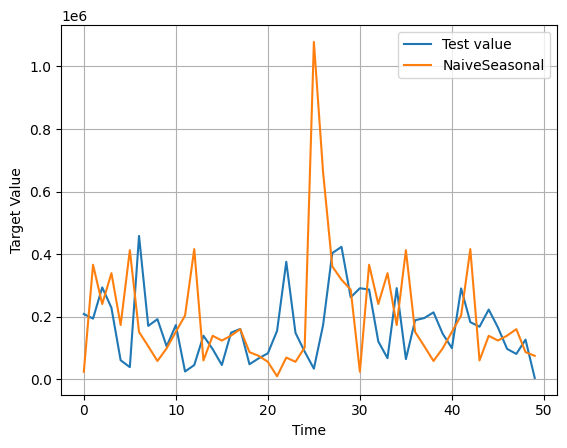

In [93]:
plt.plot(y_test.reset_index(drop=True), label='Test value')
plt.plot(season_naive, label='NaiveSeasonal')
plt.xlabel('Time')
plt.ylabel('Target Value')

plt.grid()
plt.legend();

In [94]:
print(f'MAE: {min_mae}')

MAE: 140144.0


> ### <div style='color:red'> Вывод: </div>
>
> #### Опираясь на значение метрики <code>MAE</code>, наивная модель показала наихудший результат относительно других

(0.15 балла за каждый корректно проведённый тест)

Проведите односторонний тест Диболда-Мариано для всех трёх возможных пар моделей. STL против ETS, STL против сезонной наивной, ETS против сезонной наивной. Нулевую гипотезу выберите самостоятельно, но тест должен быть односторонним. Готовую функцию с семинара используйте только для расчёта статистики, p-value подсчитайте для ваших гипотез самостоятельно. Проинтерпретируйте результаты всех трёх тестов. 

> #### Данный тест асимптотически нормальный, поэтому:
> 
> <center>
>
> ###  P-value = sts.norm.cdf(statistic\_value)
>
> </center>

In [95]:
from dieboldmariano import dm_test
import scipy.stats as sts

dmtest = {'STL vs ETS' : [dm_test(y_test.values.ravel(), y_pred_ETS, y_pred, one_sided=True)[0], sts.norm.cdf(dm_test(y_test.values.ravel(), y_pred_ETS, y_pred, one_sided=True)[0])], 
          'STL vs NaiveSeason': [dm_test(y_test.values.ravel(), season_naive.values.ravel(), y_pred, one_sided=True)[0], sts.norm.cdf(dm_test(y_test.values.ravel(), season_naive.values.ravel(), y_pred, one_sided=True)[0])],
           'ETS vs NaiveSeason': [dm_test(y_test.values.ravel(), season_naive.values.ravel(), y_pred_ETS, one_sided=True)[0], sts.norm.cdf(dm_test(y_test.values.ravel(), season_naive.values.ravel(), y_pred_ETS, one_sided=True)[0])]}


pd.DataFrame(dmtest).T.rename(columns = {0: 'Statistic', 1:'P-value'})

,Statistic,P-value
STL vs ETS,0.386976,0.650613
STL vs NaiveSeason,1.679062,0.953430
ETS vs NaiveSeason,1.640666,0.949567


> ### **<div style='color:red'>Вывод:</div>**
>
> #### Результаты теста _**Диболда-Мариано**_ следующие:
>
> * #### __**STL vs ETS:**__ На уровне значимости $\alpha = 0.05$ нулевая гипотеза не отвергается, т.е. нет оснований утверждать, что STL прогнозирует значимо лучше, чем ETS
>
> * #### __**STL vs NaiveSeason:**__ На уровне значимости $\alpha = 0.05$ нулевая гипотеза не отвергается, т.е. нет оснований утверждать, что STL прогнозирует значимо лучше, чем наивная сезонная модель
>
> * #### __**ETS vs NaiveSeason:**__ На уровне значимости $\alpha = 0.05$ нулевая гипотеза не отвергается, т.е. нет оснований утверждать, что ETS прогнозирует значимо лучше, чем наивная сезонная модель

##### Что бы вы сделали, будь у вас неприлично много денег? (0.05 балла)

P.S. Ваш семинарист хотел бы слетать в космос.

> ### **<div style='color:red'>Ответ:</div>**
>
> #### Я бы купил компанию Евраз и повысил зарплату господину Андрею Цыпченко (повышение до статуса "Карол")

##### Рубрика "как вам домашка?" (0.1 балла)

Пройдите короткий опрос. Это действительно важно. https://forms.gle/w3sV453spERTbGvr7

> #### **<div style='color:red'> Оставил </div>**